# Banana Ripeness Classification Using PLS-DA

## Overview
This notebook applies **Partial Least Squares Discriminant Analysis (PLS-DA)** to classify banana samples into three ripeness categories:  
**Green**, **Ripe**, and **Overripe**.

The goal is to:
- Evaluate how well biochemical features can distinguish ripeness stages.
- Identify which features are most important for classification.

---

## Workflow Summary

1. **Data Preparation**
   - Loaded imputed dataset 
   - Removed columns with missing values (generally whole categories for a given feature could be NaN: rather than assuming they were below detection threshold and using pseudo count, we remove the entire column ).
   - Applied log transformation to normalize feature ranges.
   - Standardized features to ensure equal weighting.

   ** Notes on preprocessed dataset: **
    - (default)Imputation uses the median value for a feature within category (green, ripe, overripe). This prevents the entire column being dropped when only 1 to 3 samples are NaN for a given column. **banana_imputed.csv**. 
    - Script contains easy toggle to switch dataset to pseudocount (small number) filled dataset to prevent dropping columns with NaNs (if preferred: by default we use the previous imputation method, which means this script will drop all columns that have any NaNs remaining). **banana_imputed_filled.csv**


2. **Label Encoding**
   - Converted ripeness categories into numerical format using one-hot encoding.

3. **Model Evaluation**
   - Tested PLS-DA with 1 to 6 components using cross-validation.
   - Selected **2 components** based on accuracy performance.

4. **Final Model**
   - Trained PLS-DA with 2 components.
   - Evaluated classification accuracy and generated a detailed report.

5. **Sanity Check**
   - Shuffled labels to confirm the model isn’t learning random noise.

6. **Visualisation**
   - Plotted PLS-DA scores to show group separation.
   - Calculated **VIP (Variable Importance in Projection)** scores to rank feature importance.

---

## Key Outputs & Interpretation

### Cross-Validated Accuracy
- Accuracy maxes to 100% at 2 components. This was unnecessary for this, because the samples are only 12 and features (even with removal of columns with NaNs) are 84 (total was 119 with no removal). This will almost certainly overfit. This just means the model will not generalise, but for this given dataset I just want to identify important features that could be useful indicators for aromatic compounds.
- However, we keep this section as it is good practice for larger datasets.

### Classification Report
- Shows precision, recall, and F1-score for each ripeness group.
- **Interpretation**: Again, because this is an overfitted, small sample model, accuracy is 100% across all metrics (only displays 2 component model)

### Sanity Check (Shuffled Labels)
- Accuracy drops significantly when labels are randomized.
- **Interpretation**: Confirms the model is learning meaningful patterns, not noise.

### PLS-DA Score Plot
- Each point represents a banana sample projected onto two PLS components.
- Colors indicate ripeness groups.
- **Interpretation**: Clear separation between groups suggests strong discriminatory power.

### VIP Scores
- Features with **VIP > 1** are considered important for classification.
- Top 15 features are visualized.
- **Interpretation**: These features are key biochemical markers for ripeness.

---

## Conclusion
This analysis demonstrates that PLS-DA can effectively classify banana ripeness based on biochemical data. The model is accurate, interpretable, and highlights the most influential features — making it a valuable tool for quality control or further research.

 ** Important note on evaluation/validity** 
    - This practice is useful for hypothesis generation of important compounds relation with an objective outcome, which requires biologicial and a biochemical interpretation. With only 12 samples and 50+ to 100+ features any ML model will overfit. This just means the model will not generalise (I.e. for prediction/ decision making tools).
    - The purpose of this practice is to develop models with early indicators of useful features and latent patterns to assist in model development, experimental design, and data collection.



Dropped columns due to missing values (35):
 - (E)-2-Pentenal Area
 - (E)-Linalool oxide Area
 - 1-Octen-3-ol Area
 - 2-Acetylpyrrole Area
 - 2-Ethylfuran Area
 - 2-Hexanone Area
 - 2-Methylpentan-2-ol Area
 - 2-Pentanol Area
 - 3-Hexanone Area
 - 3-Methyl-2-butanone Area
 - 3-Methyl-3-butenyl acetate Area
 - 6-Methoxyeugenol Area
 - Acetal Area
 - Allyl isothiocyanate Area
 - Butyl acetate Area
 - Butyric acid Area
 - Dihydrocarveol Area
 - Ethyl 2-methylbutyrate Area
 - Ethyl isobutyrate Area
 - Ethyl lactate Area
 - Ethyl vinyl ketone Area
 - Geranyl isovalerate Area
 - Isobutyric acid Area
 - Isopropyl hexanoate Area
 - Methyl 2-methylbutyrate Area
 - Methyl hexanoate Area
 - Methyl isobutyl ketone Area
 - Methyl isovalerate Area
 - Neodihydrocarveol Area
 - Propanoic acid Area
 - Propyl acetate Area
 - Tetrahydrothiophene Area
 - alpha-Pinene Area
 - beta-Pinene Area
 - cis-3-Hexen-1-ol Area

Cross-validated accuracy by number of PLS components:
Components: 1, Accuracy: 0.5833
Co

C:\Users\uqkmuroi\AppData\Local\Temp\ipykernel_26452\2045882162.py:116: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Set1', len(unique_classes))


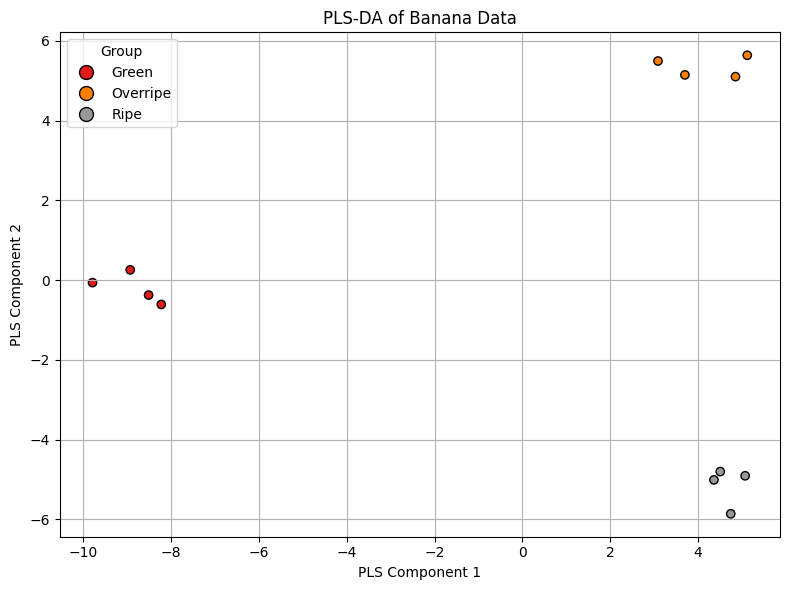

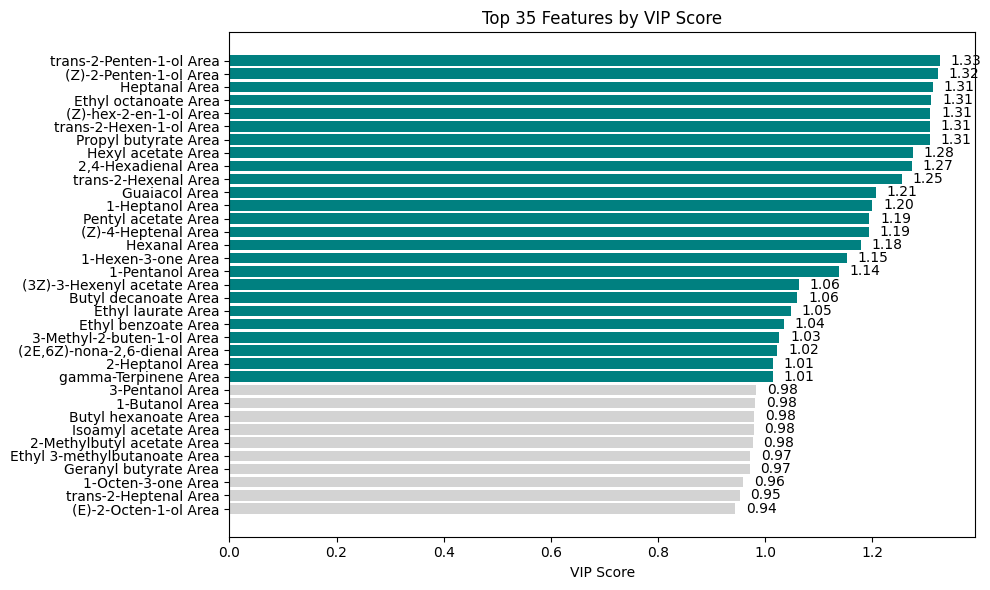

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import shuffle
from sklearn import __version__ as sklearn_version
from packaging import version


# ----------------------
# Step 1: Load and clean
# ----------------------

'''
Choice here between filled data or non-filled 
'''
# Load the dataset (group impute, nans filled with pseudocount)
#df = pd.read_csv("badata_imputed_filled.csv")

df = pd.read_csv('badata_imputed.csv') #this one imputes median of category per column if available but has many NaNs
'''
pick the preproces file above carefully
'''

df = df.drop(columns=[df.columns[0]])  # drop unnamed index column

# Separate features and target
y_raw = df['Groups']
X_raw = df.drop(columns=['Groups'])

# Identify and drop columns with any missing values
missing_cols = X_raw.columns[X_raw.isna().any()].tolist()
print(f"\nDropped columns due to missing values ({len(missing_cols)}):")
for col in missing_cols:
    print(f" - {col}")

X_clean = X_raw.drop(columns=missing_cols)
# the above will do nothing if data has no NaNs

# log transofrm the aromatics data as it spans large ranges approx 70 to over 1000000
X_log = np.log10(X_clean)

# Standardize the data so that pls-da considers each feature equally (doesn't get biased by larger variance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)


encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y_raw.values.reshape(-1, 1))
class_labels = encoder.categories_[0]
y_labels = np.argmax(y, axis=1)


# ------------------------------
# Step 2: Cross-validation test
# ------------------------------
# tests best number of components for plsreg (this just checks if more components improve)
print("\nCross-validated accuracy by number of PLS components:")
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

for n_components in range(1, 7):
    y_pred_all = np.zeros_like(y)
    
    for train_idx, test_idx in skf.split(X_scaled, y_labels):
        pls = PLSRegression(n_components=n_components)
        pls.fit(X_scaled[train_idx], y[train_idx])
        y_pred_all[test_idx] = pls.predict(X_scaled[test_idx])
    
    y_pred_labels = np.argmax(y_pred_all, axis=1)
    acc = accuracy_score(y_labels, y_pred_labels)
    print(f"Components: {n_components}, Accuracy: {acc:.4f}")
# in the aromatics data this shows 2 is enough


# ------------------------------
# Step 3: Fit final model (2 comps)
# ------------------------------

pls = PLSRegression(n_components=2)
X_scores, _ = pls.fit_transform(X_scaled, y)

# Use regular KFold for one-hot regression predictions
kf = KFold(n_splits=3, shuffle=True, random_state=1)
y_pred_probs = cross_val_predict(pls, X_scaled, y, cv=kf)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

acc = accuracy_score(y_labels, y_pred_labels)
print(f"\nFinal CV Accuracy (2 components): {acc:.2f}")
print(classification_report(y_labels, y_pred_labels, target_names=class_labels))


# ------------------------------
# Step 4: Sanity check (shuffled labels)
# ------------------------------

y_labels_shuffled = shuffle(y_labels, random_state=42)
y_shuffled = np.eye(len(class_labels))[y_labels_shuffled]

y_pred_shuffled = cross_val_predict(pls, X_scaled, y_shuffled, cv=kf)
acc_shuffled = accuracy_score(y_labels_shuffled, np.argmax(y_pred_shuffled, axis=1))
print(f"\nSanity check (shuffled labels) accuracy: {acc_shuffled:.2f}")


# ------------------------------
# Step 5: PLS-DA score plot
# ------------------------------

# Dynamic color map
unique_classes = sorted(y_raw.unique())
color_map = {label: i for i, label in enumerate(unique_classes)}
colors = y_raw.map(color_map)
cmap = plt.cm.get_cmap('Set1', len(unique_classes))

plt.figure(figsize=(8, 6))
plt.scatter(X_scores[:, 0], X_scores[:, 1], c=colors, cmap=cmap, edgecolor='k')
plt.xlabel('PLS Component 1')
plt.ylabel('PLS Component 2')
plt.title('PLS-DA of Banana Data')

# Legend
handles = [plt.Line2D([], [], marker='o', color='w', markerfacecolor=cmap(i),
                      label=label, markersize=10, markeredgecolor='k')
           for label, i in color_map.items()]
plt.legend(handles=handles, title='Group')
plt.grid(True)
plt.tight_layout()
plt.show()


# ------------------------------
# Step 6: VIP score calculation
# ------------------------------

def calculate_vip(pls_model, X_scaled, y_onehot):
    t = pls_model.x_scores_
    w = pls_model.x_weights_
    q = pls_model.y_loadings_

    p, h = w.shape
    s = np.zeros(h)
    for i in range(h):
        s[i] = np.sum((t[:, i] ** 2) * np.sum(q[:, i] ** 2))

    total_s = np.sum(s)
    vip = np.zeros(p)
    for i in range(p):
        weight = np.array([(w[i, j] ** 2) * s[j] for j in range(h)])
        vip[i] = np.sqrt(p * np.sum(weight) / total_s)
    return vip

vip_scores = calculate_vip(pls, X_scaled, y)
vip_df = pd.DataFrame({'Feature': X_clean.columns, 'VIP': vip_scores})
vip_df_sorted = vip_df.sort_values(by='VIP', ascending=False)


# ------------------------------
# Step 7: VIP bar plot
# ------------------------------

top_n = 35
top_vips = vip_df_sorted.head(top_n)
vip_colors = ['teal' if v > 1 else 'lightgray' for v in top_vips['VIP']]

plt.figure(figsize=(10, 6))
plt.barh(top_vips['Feature'][::-1], top_vips['VIP'][::-1], color=vip_colors[::-1])
for i, v in enumerate(top_vips['VIP'][::-1]):
    plt.text(v + 0.02, i, f"{v:.2f}", va='center')
plt.xlabel('VIP Score')
plt.title(f'Top {top_n} Features by VIP Score')
plt.tight_layout()
plt.show()
